In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import fastai
from fastai.vision import *
from fastai.vision.learner import model_meta
from fastai.callbacks import *
from fastai.utils.mem import *
import pretrainedmodels
from torchvision.models import *
from utils import *
# torch.cuda.set_enabled_lms(True)

### Path to Dataset

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
# path_llr = path/'small-32'
path_lr = path/'small-96'
path_mr = path/'small-256'
il = ImageList.from_folder(path_hr)
path_hr

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')

### Default Basic HyperParams

In [4]:
def_bs =16
def_size = 128
lr = 1e-3

### Helper Functions

In [5]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [6]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [7]:
def get_data(bs=def_bs,size=def_size,norm_stats=None,src=ImageImageList.from_folder(path_lr)):
#     imagenet_stats, do_y=True
    data = (src.split_by_rand_pct(0.1, seed=42)
            .label_from_func(lambda x: path_hr/x.name)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs).normalize())

    data.c = 3
    return data

In [8]:
# Cutter Callable for making it work with fastai for model from fastai
def fast_ai_efficient_net_cutter(model):
    swish = (list(model.children())[-1])
    new_model = [*list(efficiennet_model.children())[:-5]]
    new_model.append(swish)
    return nn.Sequential(*new_model)

def efficientnet_b1_fastai(pretrained=False):
    data_temp = type('',(object,),{"c": 3})()
    return models.EfficientNetB1(data_temp)

fast_ai_efficientnet_b1_meta = {'cut': fast_ai_efficient_net_cutter,'split': lambda m: (m[0][0][11], m[1]) }
model_meta[efficientnet_b1_fastai]=fast_ai_efficientnet_b1_meta

In [9]:
def efficientnet_b1_image_model(pretrained=False):
    return ptcv_get_model("efficientnet_b1", pretrained=pretrained).features

def efficientnet_b0_image_model(pretrained=False):
    return ptcv_get_model("efficientnet_b0", pretrained=pretrained).features

def efficientnet_b2_image_model(pretrained=False):
    return ptcv_get_model("efficientnet_b2b", pretrained=pretrained).features
# FastAI Model Metas
ptcv_efficientnet_b0_meta = {'cut': -2,'split': lambda m: (m[0][4], m[1])}
model_meta[efficientnet_b0_image_model]={**ptcv_efficientnet_b0_meta}

ptcv_efficientnet_b1_meta = {'cut': -2,'split': lambda m: (m[0][3], m[1]) }
model_meta[efficientnet_b1_image_model]={**ptcv_efficientnet_b1_meta}


In [11]:
# data_temp = get_data(bs,size)
# efficiennet_model = models.EfficientNetB1(data_temp);
# efficiennet_model = efficient_net_cutter(efficiennet_model)
# arch_summary(lambda x: list(efficiennet_model.children())[2])

model = efficientnet_b1_image_model
arch_summary(model)
print("\n")
for i in range(7):
    print(f'---------({i})---------')
    arch_summary(lambda _: model()[i])

(0) EffiInitBlock: 3   layers (total: 3)
(1) Sequential  : 20  layers (total: 23)
(2) Sequential  : 39  layers (total: 62)
(3) Sequential  : 39  layers (total: 101)
(4) Sequential  : 104 layers (total: 205)
(5) Sequential  : 91  layers (total: 296)
(6) ConvBlock   : 3   layers (total: 299)
(7) AdaptiveAvgPool2d: 1   layers (total: 300)


---------(0)---------
(0) ConvBlock   : 3   layers (total: 3)
---------(1)---------
(0) EffiDwsConvUnit: 10  layers (total: 10)
(1) EffiDwsConvUnit: 10  layers (total: 20)
---------(2)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
---------(3)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
---------(4)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
(3) EffiInvResUnit: 13  layers (tot

In [12]:
flatten_model = lambda m: sum(map(flatten_model,children_and_parameters(m)),[]) if num_children(m) else [m]

In [13]:
def in_channels(m:nn.Module) -> List[int]:
    "Return the shape of the first weight layer in `m`."
    for l in flatten_model(m):
        if hasattr(l, 'weight'): return l.weight.shape[1]
    raise Exception('No weight layer')

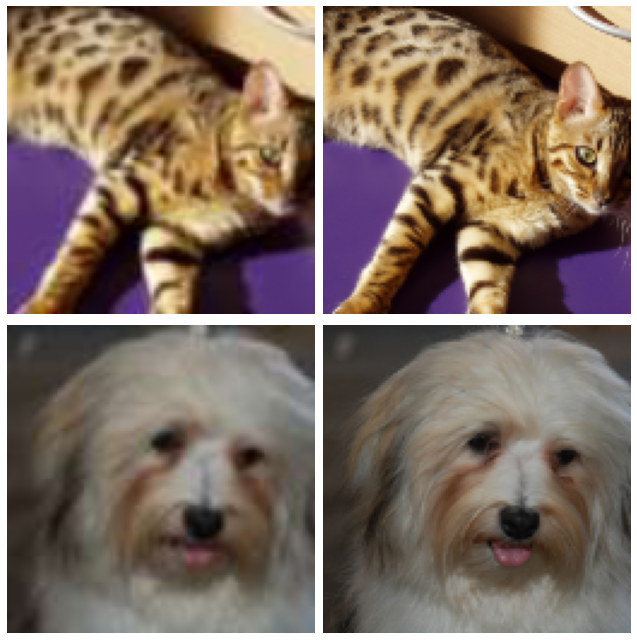

In [12]:
data = get_data()
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

### Feature Loss

In [13]:
t = data.valid_ds[0][1].data
print(t[0])
t = torch.stack([t,t])

tensor([[0.1405, 0.1497, 0.1794,  ..., 0.9298, 0.9347, 0.9367],
        [0.1315, 0.1170, 0.1605,  ..., 0.9418, 0.9230, 0.9220],
        [0.1682, 0.2821, 0.4084,  ..., 0.9467, 0.9462, 0.9399],
        ...,
        [0.3421, 0.3508, 0.3454,  ..., 0.3328, 0.3327, 0.3279],
        [0.3500, 0.3412, 0.3338,  ..., 0.3321, 0.3355, 0.3370],
        [0.3485, 0.3364, 0.3602,  ..., 0.3317, 0.3383, 0.3284]])


In [14]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
gram_matrix(t)

tensor([[[0.1137, 0.0930, 0.0734],
         [0.0930, 0.0774, 0.0605],
         [0.0734, 0.0605, 0.0542]],

        [[0.1137, 0.0930, 0.0734],
         [0.0930, 0.0774, 0.0605],
         [0.0734, 0.0605, 0.0542]]])

In [16]:
base_loss = F.l1_loss

In [17]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [18]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [19]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [20]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [21]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

In [22]:
def clean_mem():
    dump_tensors()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()
# if 'resnext_learn' in locals():resnext_learn.destroy()


### Train

In [25]:
# efficientnet_learner.model[0][-1]
# efficientnet_learner.model[1]
# efficientnet_learner.layer_groups[1]
# get_groups(nn.Sequential(*efficientnet_learner.model[0], *efficientnet_learner.model[1]), efficientnet_learner.layer_groups)

In [23]:
def upscale_model_output(model,bs = def_bs,bs_factor=1,size_factor=1,label_size=128):
    model.data = get_data(bs*bs_factor,label_size*size_factor)
    model.to_fp16()
    clean_mem()
    print(f'Current training data hyperparams :\n batch size = {bs * bs_factor}\n label size = {label_size*size_factor}')

In [24]:
def do_fit(learn,save_name,lrs=slice(lr), pct_start=0.9,epoch = 10,override_path=False):
    target_path = (efficientnet_learner.path)/efficientnet_learner.model_dir/f'{save_name}.pth'
    if not override_path and target_path.exists():
        raise Exception("The specified save file exists. Please pass argument override_path = True")
    clean_mem()
    print(f'Saving weights to {str(target_path)}')
    learn.fit_one_cycle(epoch, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=3, imgsize=9)

In [25]:
# Return model with basename for the specified model.
def get_model(model):
    model_dict={
        efficientnet_b0_image_model:'efficient-net0',
        efficientnet_b1_image_model:'efficient-net1',
        models.resnet34:'resnet34',
        models.resnet50:'resnet50'
    }
    return model,model_dict[model]

In [26]:
wd = 1e-3
arch,basename = get_model(efficientnet_b1_image_model)
data = get_data()

In [27]:
# arch_summary(resnext50_32x4d)
# arch_summary(efficientnetb1)
# resnext50_32x4d
# vars(efficientnetb1(True))
# model = ptcv_get_model("efficientnet_b1", pretrained=False)
# model
# children_and_parameters(model)
# list(flatten_model(model)[1].children())
# vars(model)

efficientnet_learner = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight).to_fp16()
efficientnet_learner.summary()
# efficientnet_learner.model

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 64, 64]         864        False     
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
Swish                [32, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [32, 64, 64]         288        False     
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
Swish                [32, 64, 64]         0          False     
______________________________________________________________________
AdaptiveAvgPool2d    [32, 1, 1]           0          False     
__________________________________________________

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


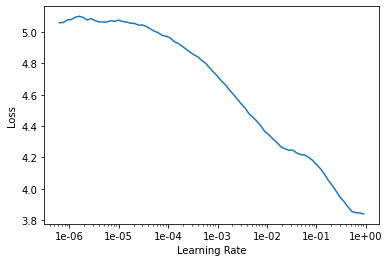

In [68]:
efficientnet_learner.lr_find()
efficientnet_learner.recorder.plot()

In [38]:
lr = 1e-3

/opt/conda/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Total size: 217211967
Saving weights to /home/jupyter/.fastai/data/oxford-iiit-pet/small-96/models/efficient-net1-1a.pth


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.042280,3.123235,0.168747,0.246372,0.326072,0.188332,0.534627,1.042275,0.616810,01:44
1,2.396975,2.407851,0.064316,0.186676,0.257958,0.158663,0.383476,0.798315,0.558447,01:44
2,2.097893,2.129914,0.040901,0.159777,0.224988,0.142780,0.336010,0.707710,0.517748,01:44
3,2.000106,2.029886,0.039796,0.157784,0.219068,0.137295,0.308637,0.668676,0.498631,01:45
4,1.968691,1.961375,0.036310,0.153171,0.212205,0.134415,0.287021,0.647595,0.490657,01:44
5,1.977403,1.920991,0.035313,0.151494,0.209574,0.131468,0.277482,0.635259,0.480401,01:44
6,1.912561,1.913475,0.038005,0.151301,0.208338,0.129685,0.281303,0.630358,0.474483,01:44
7,1.912154,1.884245,0.034579,0.149877,0.205449,0.128449,0.275108,0.620225,0.470557,01:44
8,1.901338,1.842290,0.034233,0.147935,0.202684,0.125711,0.264527,0.608127,0.459073,01:45
9,1.856144,1.799780,0.032434,0.145681,0.199380,0.122707,0.255295,0.594763,0.449520,01:44


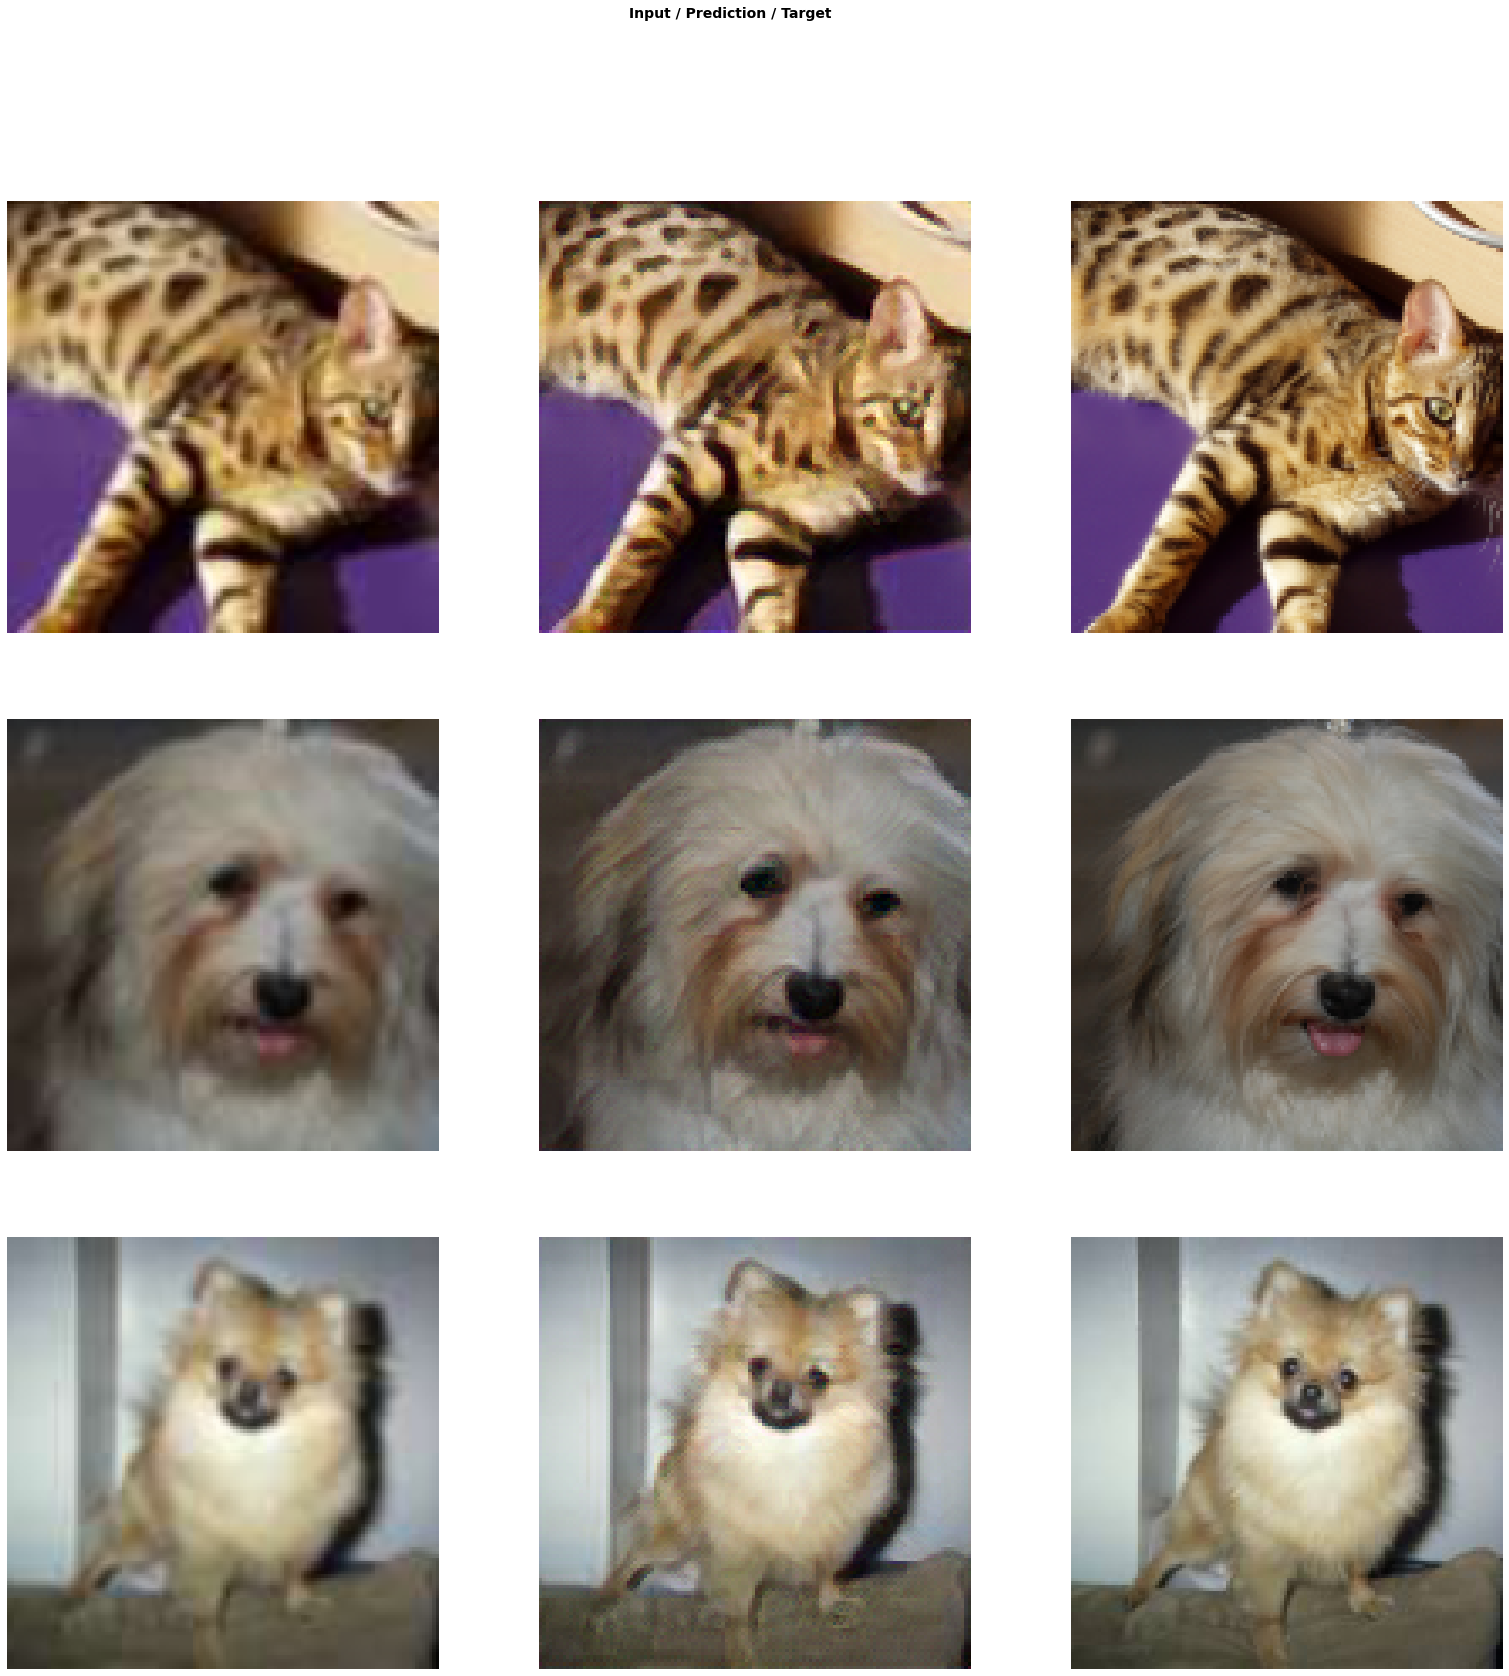

In [69]:
do_fit(efficientnet_learner,basename+'-1a')
# efficientnet_learner.data.label_list

/opt/conda/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Total size: 211678320
Current training data hyperparams :
 batch size = 16
 label size = 128
Total size: 211678320
Saving weights to /home/jupyter/.fastai/data/oxford-iiit-pet/small-96/models/efficient-net1-1b.pth


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.842759,1.803075,0.033514,0.146426,0.200157,0.122747,0.255741,0.595761,0.448730,02:05
1,1.870195,1.844319,0.037534,0.148017,0.203069,0.123760,0.268586,0.608256,0.455097,02:06
2,1.887845,1.836235,0.034276,0.147306,0.201991,0.124359,0.264758,0.605427,0.458118,02:05
3,1.863028,1.834190,0.036847,0.146678,0.201215,0.123655,0.267271,0.606316,0.452207,02:06
4,1.878473,1.889797,0.032244,0.144836,0.202283,0.127051,0.287616,0.630100,0.465668,02:06
5,1.865343,1.811454,0.034089,0.146146,0.199937,0.123121,0.257292,0.597501,0.453369,02:06
6,1.834266,1.769266,0.034206,0.144459,0.196049,0.119014,0.253195,0.584575,0.437768,02:06
7,1.826055,1.773593,0.033269,0.145184,0.196718,0.119588,0.253949,0.584977,0.439907,02:06
8,1.798097,1.748867,0.031867,0.142298,0.192921,0.117963,0.251184,0.578409,0.434224,02:07
9,1.733300,1.689189,0.031372,0.140302,0.188581,0.113809,0.237070,0.558937,0.419119,02:06


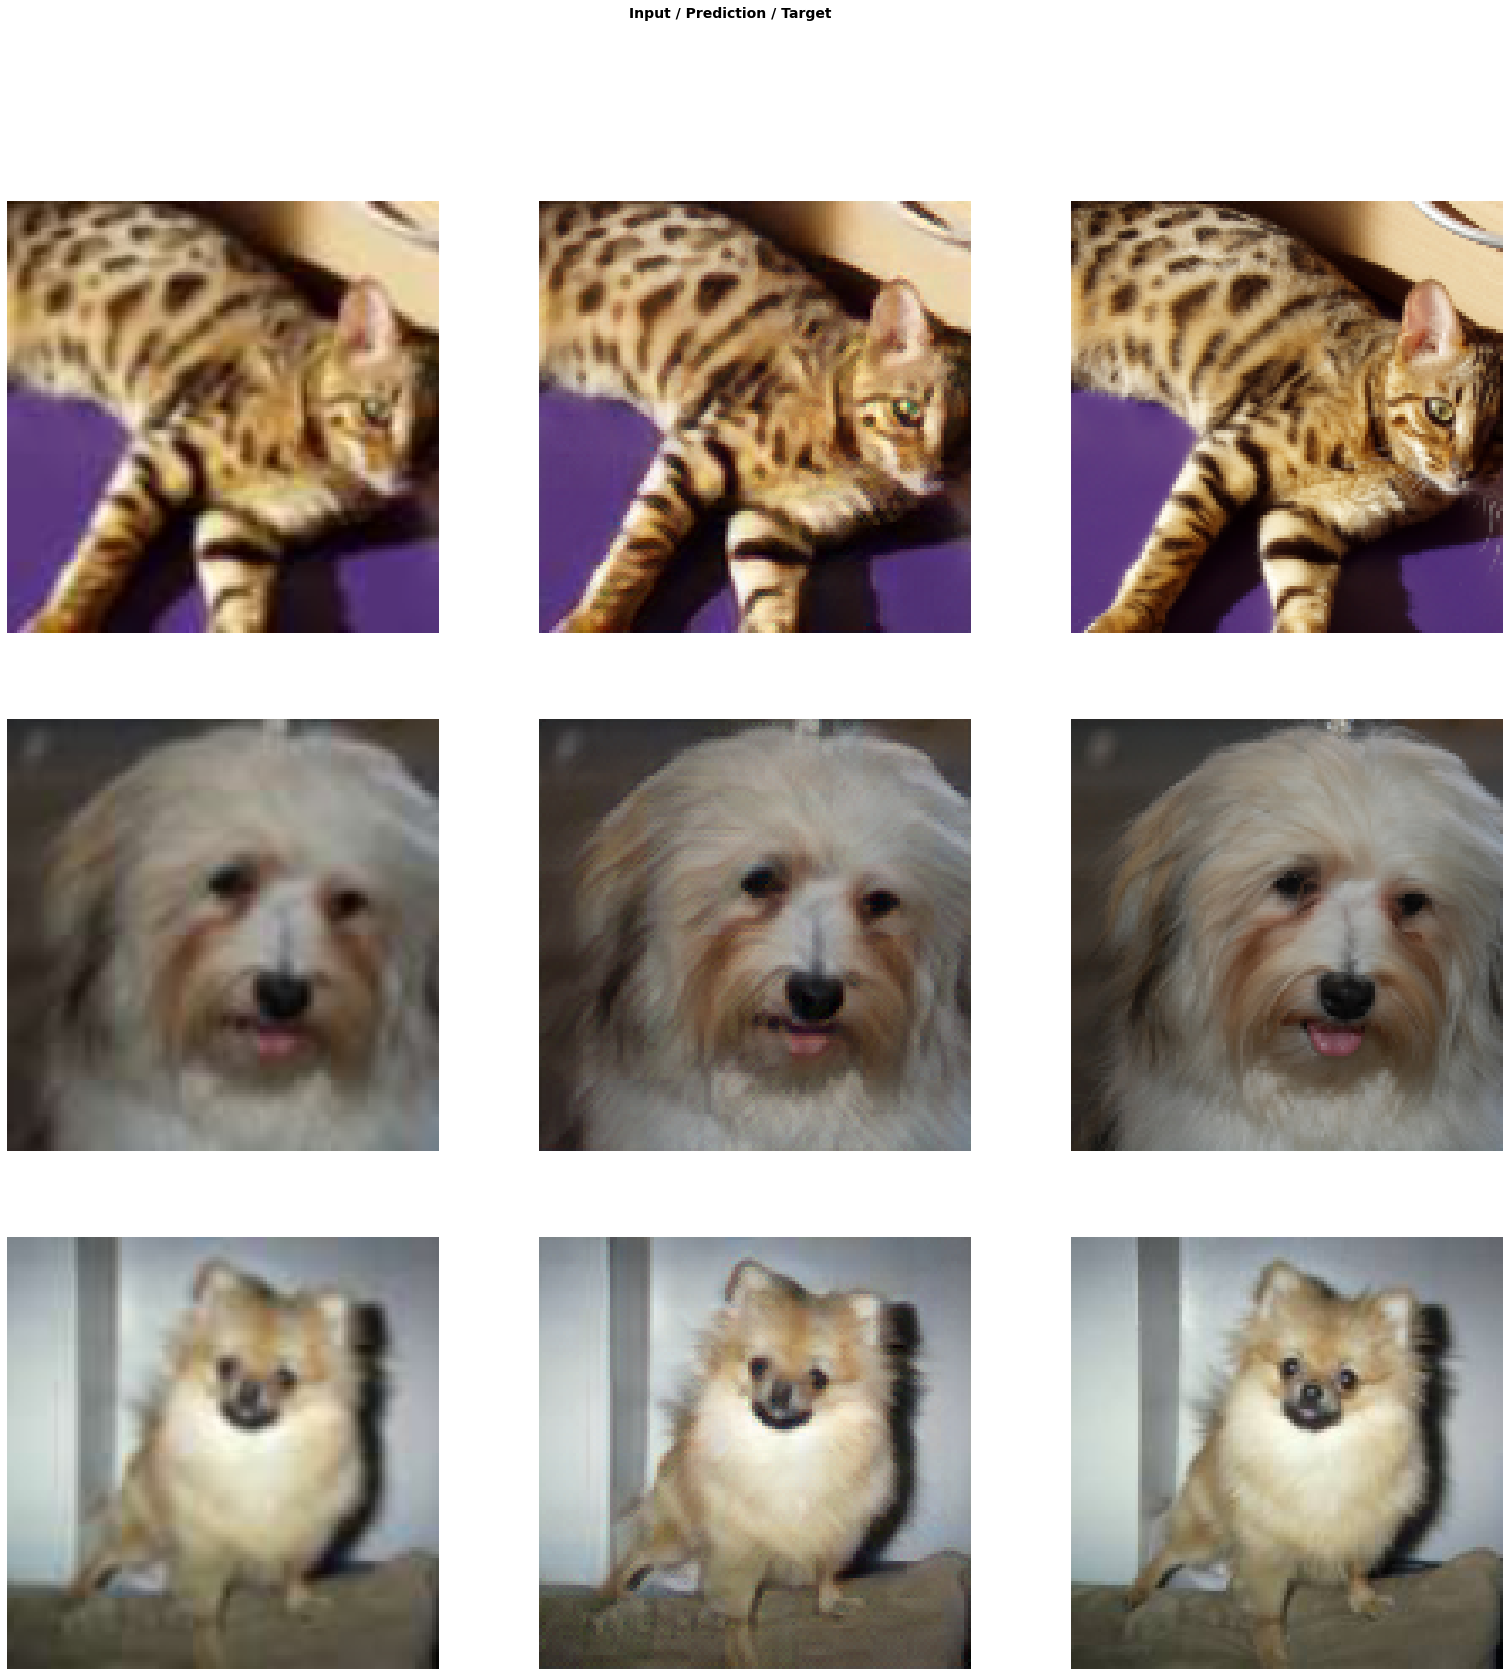

In [70]:
efficientnet_learner.load(basename+'-1a')
efficientnet_learner.unfreeze() 
upscale_model_output(efficientnet_learner,bs_factor=1,size_factor=1)
do_fit(efficientnet_learner,basename+'-1b',lrs = slice(1e-4,1e-2))

In [75]:
upscale_model_output(efficientnet_learner,bs_factor=1,size_factor=2)
# Let's upscale size factor of output to 256

/opt/conda/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Total size: 433525410
Current training data hyperparams :
 batch size = 16
 label size = 256


Total size: 157602178
Saving weights to /home/jupyter/.fastai/data/oxford-iiit-pet/small-96/models/efficient-net1-2a.pth


/opt/conda/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.746134,1.685615,0.031433,0.140425,0.188554,0.113553,0.236037,0.557265,0.418347,01:45
1,1.743677,1.682017,0.031561,0.140457,0.188533,0.113459,0.234153,0.555969,0.417884,01:43
2,1.740519,1.681284,0.031360,0.140139,0.188257,0.113292,0.235019,0.556225,0.416991,01:42
3,1.737014,1.677246,0.031469,0.139706,0.187774,0.112976,0.234577,0.554908,0.415834,01:42
4,1.743696,1.676223,0.031250,0.139584,0.187413,0.112608,0.235841,0.554854,0.414673,01:42
5,1.735861,1.672563,0.031219,0.139137,0.186830,0.112467,0.235352,0.554315,0.413243,01:42
6,1.707681,1.670969,0.031564,0.139983,0.187651,0.112736,0.232397,0.552617,0.414021,01:42
7,1.733738,1.669055,0.031098,0.138717,0.186524,0.111997,0.235858,0.553709,0.411152,01:42
8,1.716314,1.664338,0.031320,0.139111,0.186618,0.111839,0.232453,0.551464,0.411535,01:42
9,1.729273,1.657576,0.031254,0.138848,0.186066,0.111349,0.231380,0.549251,0.409428,01:42


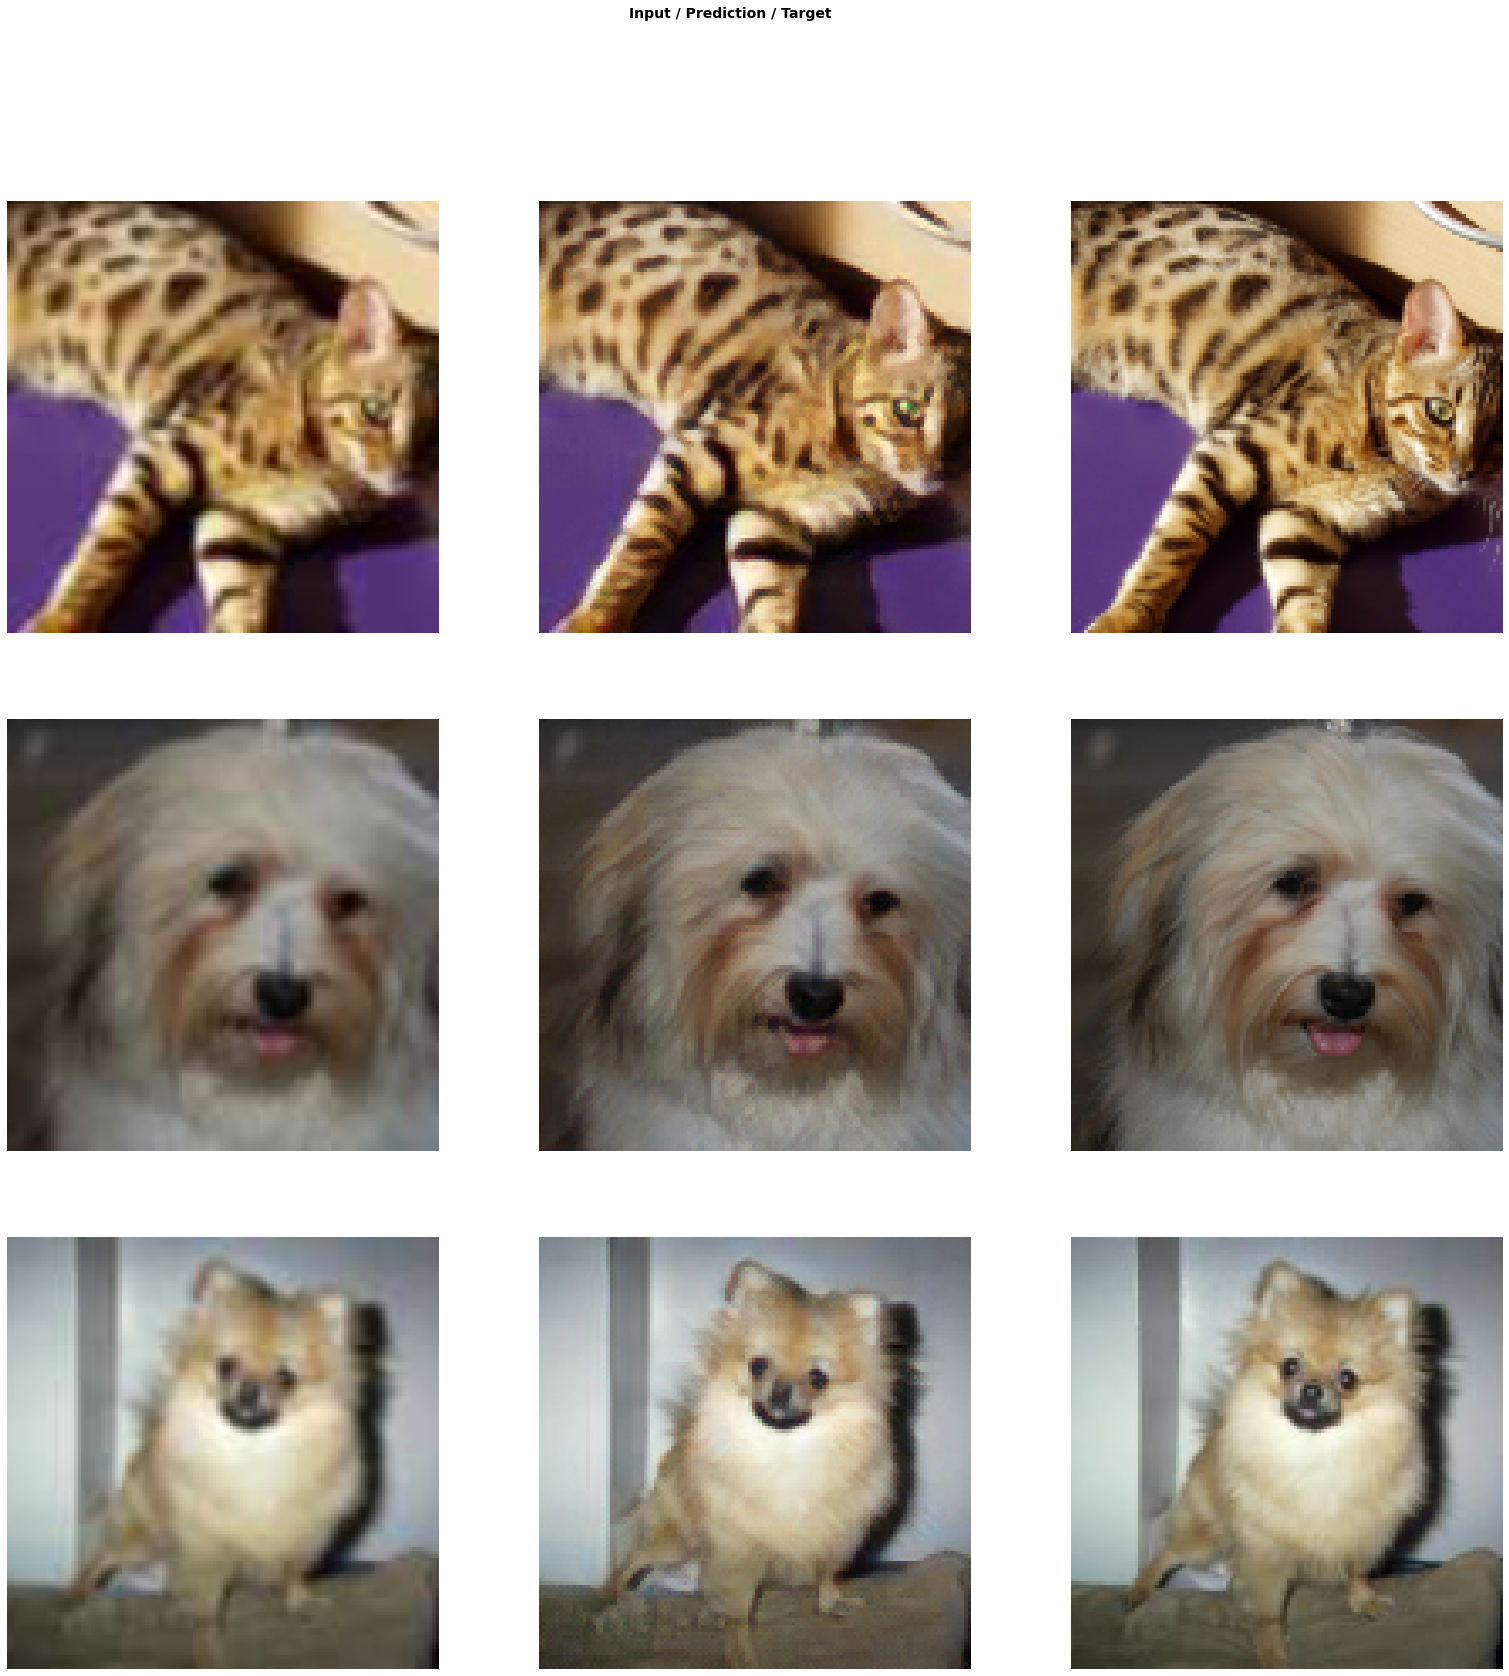

In [28]:
efficientnet_learner.load(basename+'-1b')
efficientnet_learner.freeze() 
do_fit(efficientnet_learner,basename+'-2a',override_path=True)
# put lr at 1e-3

/opt/conda/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Total size: 179630375
Saving weights to /home/jupyter/.fastai/data/oxford-iiit-pet/small-96/models/efficient-net1-2b.pth


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.710649,1.657761,0.031325,0.138971,0.186168,0.111403,0.231181,0.549299,0.409415,02:05
1,1.719154,1.656267,0.031356,0.138868,0.186073,0.111287,0.230763,0.548721,0.409199,02:04
2,1.713859,1.655347,0.031345,0.138889,0.185989,0.111215,0.230850,0.548528,0.408531,02:04
3,1.717950,1.653985,0.031331,0.138662,0.185782,0.111099,0.230858,0.548117,0.408136,02:04
4,1.718702,1.655340,0.031375,0.138870,0.185991,0.111165,0.230735,0.548522,0.408682,02:04
5,1.705670,1.654231,0.031319,0.138813,0.185863,0.111142,0.230437,0.548318,0.408339,02:05
6,1.712234,1.653949,0.031294,0.138744,0.185787,0.111073,0.230740,0.548181,0.408129,02:05
7,1.728780,1.652535,0.031365,0.138771,0.185753,0.111036,0.230062,0.547357,0.408192,02:05
8,1.722310,1.653151,0.031416,0.138847,0.185856,0.111063,0.230126,0.547630,0.408213,02:05
9,1.718499,1.652325,0.031403,0.138889,0.185808,0.111036,0.229804,0.547371,0.408013,02:05


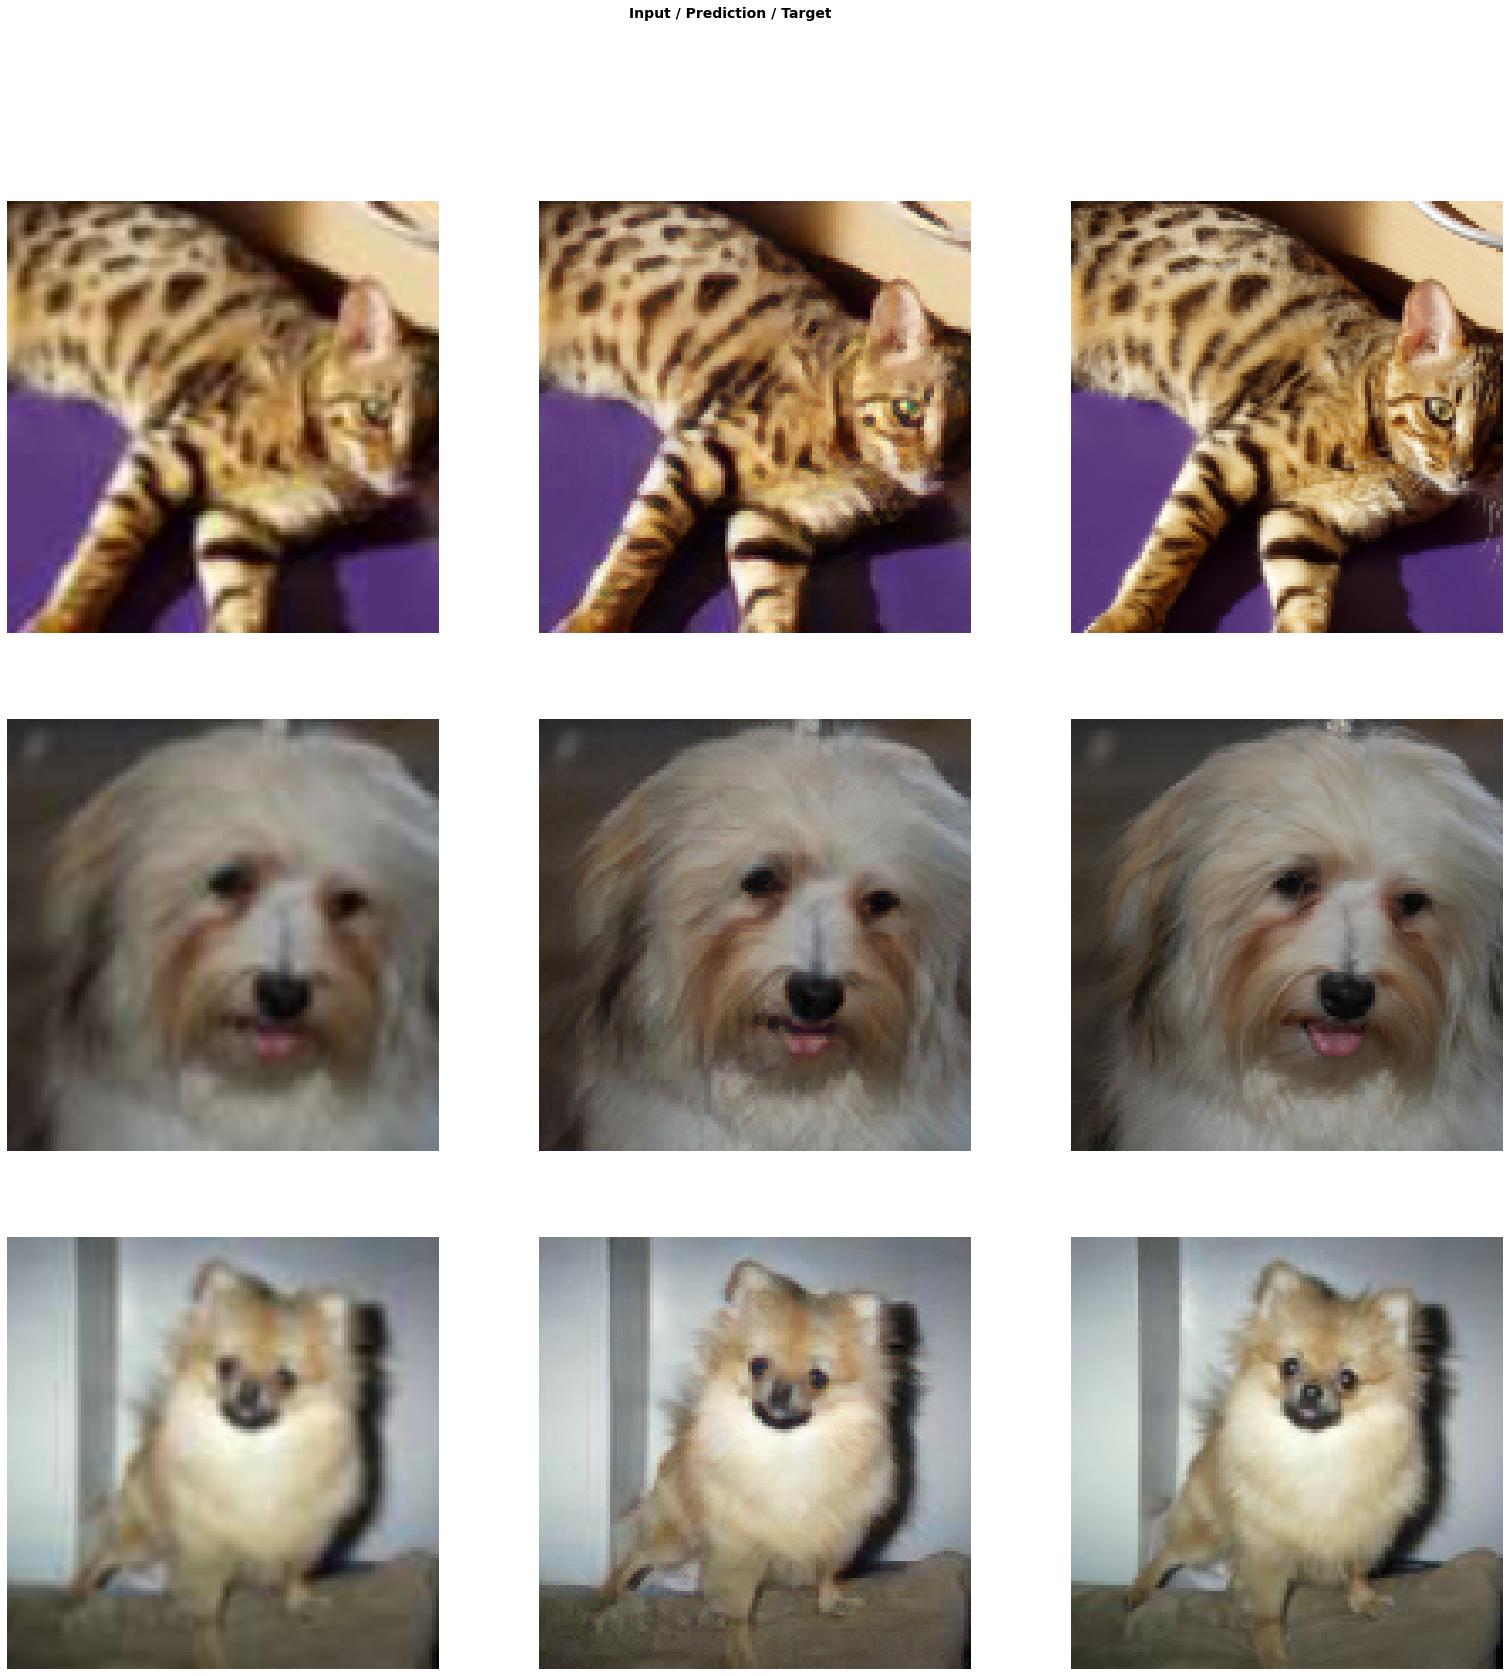

In [30]:
efficientnet_learner.load(basename+'-2a')
efficientnet_learner.unfreeze() 
do_fit(efficientnet_learner,basename+'-2b', slice(1e-6,1e-4), pct_start=0.3)

### Test it


In [31]:
efficientnet_learner = None
clean_mem()

/opt/conda/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Total size: 197754983


In [32]:
free = gpu_mem_get_free_no_cache()

In [33]:
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 13747MB of GPU RAM free


In [50]:
size=(1280, 1600) 

In [34]:
arch,basename=get_model(efficientnet_b1_image_model)

In [35]:
efficientnet_learner = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [36]:
# data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
#           .label_from_func(lambda x: path_hr/x.name)
#           .transform(get_transforms(),size=size, tfm_y=True)
#           .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(),size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [37]:
efficientnet_learner.load(basename+'-2b');

In [38]:
efficientnet_learner.data= data_mr
efficientnet_learner.to_fp16();

In [39]:
fn = data_mr.valid_ds.x.items[1];fn

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-256/havanese_51.jpg')

In [40]:
img = open_image(fn); img.shape

torch.Size([3, 256, 384])

In [41]:
p,img_hr,b = efficientnet_learner.predict(img)

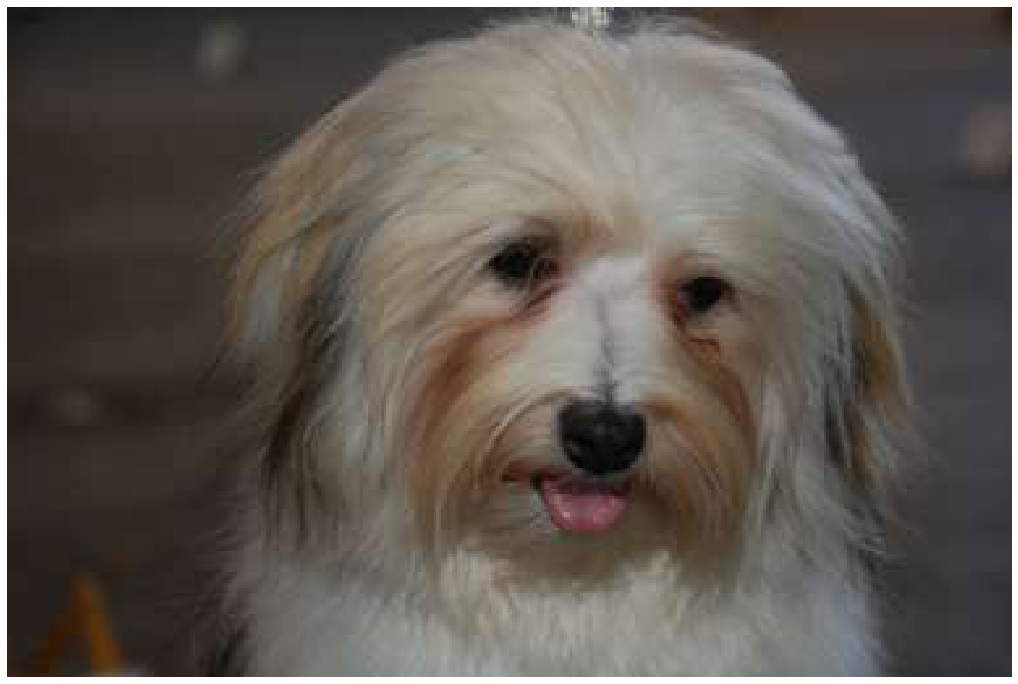

In [42]:
show_image(img, figsize=(18,15), interpolation='nearest');

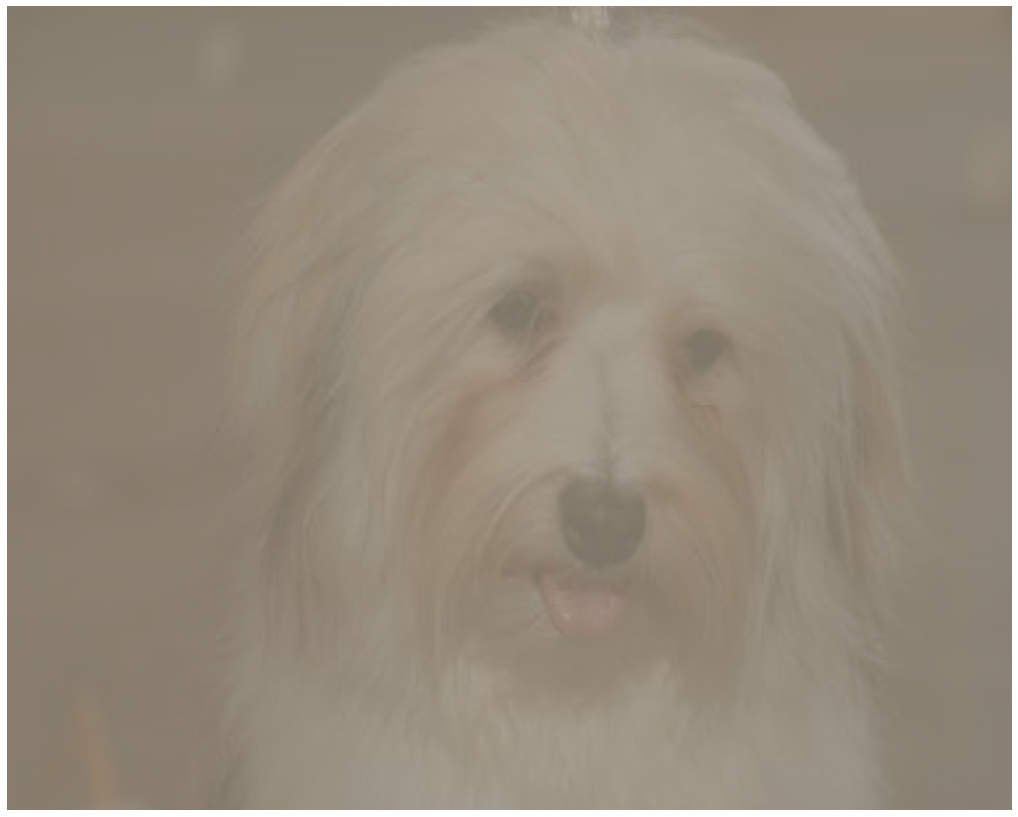

In [43]:
Image(img_hr).show(figsize=(18,15))